## Libraries

In [5]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

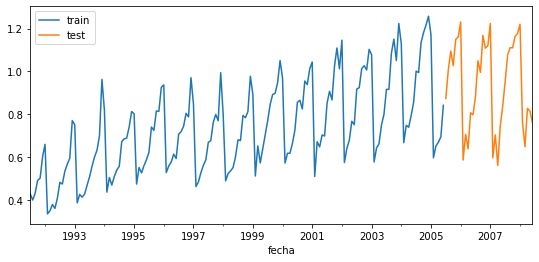

In [6]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Grid search with time series cross-validation

In [7]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Placeholder, the value will be overwritten
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-08-28 18:55:02,695 root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:10<00:00,  3.39s/it]
2021-08-28 18:55:12,870 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [1 2 3] 
params: {'max_depth': 10, 'n_estimators': 50}



In [8]:
print(results_grid.to_markdown(tablefmt="github"))

|    | lags                            | params                                 |   metric |   max_depth |   n_estimators |
|----|---------------------------------|----------------------------------------|----------|-------------|----------------|
|  2 | [1 2 3]                         | {'max_depth': 10, 'n_estimators': 50}  | 0.777254 |          10 |             50 |
|  4 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 50}   | 0.785111 |           5 |             50 |
|  6 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 50}  | 0.786625 |          10 |             50 |
|  5 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 100}  | 0.786647 |           5 |            100 |
| 10 | [ 1  2  3 20]                   | {'max_depth': 10, 'n_estimators': 50}  | 0.789526 |          10 |             50 |
|  7 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 100} | 0.791644 |          10 |            100 |
|  0 | [

In [10]:
forecaster

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123)
Lags: [1 2 3]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

## Grid search with backtesting

In [11]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Placeholder, the value will be overwritten
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-08-28 18:56:02,518 root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]
2021-08-28 18:56:07,512 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



In [12]:
print(results_grid.to_markdown(tablefmt="github"))

|    | lags                            | params                                 |    metric |   max_depth |   n_estimators |
|----|---------------------------------|----------------------------------------|-----------|-------------|----------------|
| 10 | [ 1  2  3 20]                   | {'max_depth': 10, 'n_estimators': 50}  | 0.0500237 |          10 |             50 |
|  2 | [1 2 3]                         | {'max_depth': 10, 'n_estimators': 50}  | 0.0543223 |          10 |             50 |
|  7 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 100} | 0.0568267 |          10 |            100 |
|  0 | [1 2 3]                         | {'max_depth': 5, 'n_estimators': 50}   | 0.0569292 |           5 |             50 |
|  8 | [ 1  2  3 20]                   | {'max_depth': 5, 'n_estimators': 50}   | 0.0575393 |           5 |             50 |
|  5 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 100}  | 0.0584062 |           5 |            100 |


In [13]:
forecaster

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123)
Lags: [ 1  2  3 20]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}